project, centered on analyzing India's electric vehicle market through sales data, customer reviews, and technical specifications, sounds like an in-depth study. This will help identify market trends, customer preferences, and the technical aspects that drive the EV market in India.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import  PCA
from sklearn.cluster import KMeans
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import missingno as msno

### Sales Data

The Society of Manufacturers of Electric Vehicles (SMEV) has compiled sales data for electric two-wheelers, three-wheelers, four-wheelers, and buses from 2017 to 2023. This dataset offers a comprehensive overview of the Indian electric vehicle market, enabling analysis of sales trends, consumer preferences, and industry performance.

In [40]:
# Reading the Dataset
df = pd.read_excel('smev_data (1).xlsx',sheet_name=None)
df.keys()

dict_keys(['EV 2W FY 19-20', 'EV 2W FY 20-21', 'EV 2W FY 21-22', 'EV 2W FY 22-23', 'EV Market', 'Electric Bus Sales', 'Electric 4-Wheeler Sales', 'Electric 3-Wheeler Sales', 'Electric 2-Wheeler Sales', 'EV Industries'])

In [41]:
df['EV Industries']

,category,financial_year,num_vehicles
0,E-2 Wheelers,2017-18,1981
1,E-2 Wheelers,2018-19,27478
2,E-2 Wheelers,2019-20,26512
3,E-2 Wheelers,2020-21,44294
4,E-2 Wheelers,2021-22,249615
5,E-2 Wheelers,2022-23,728090
6,E-3 Wheelers,2017-18,91970
7,E-3 Wheelers,2018-19,116031
8,E-3 Wheelers,2019-20,143051
9,E-3 Wheelers,2020-21,90898


"The figure above illustrates the substantial growth of India's two-wheeler market in 2023, solidifying its position as an industry leader."

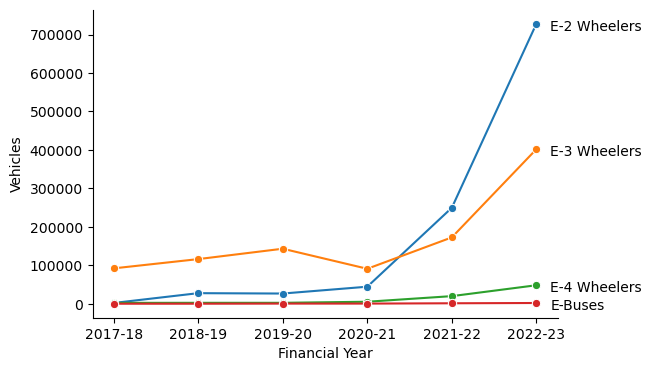

In [171]:

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data=df['EV Industries'], x='financial_year', y='num_vehicles', hue='category', marker='o', palette='tab10')
plt.xlabel("Financial Year")
plt.ylabel("Vehicles")
plt.legend(title='Category')

# Annotate the last data point
for col in df['EV Industries']['category'].unique():
    last_point = df['EV Industries'][df['EV Industries']['category'] == col].iloc[-1]
    plt.annotate(f"{last_point['category']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().set_visible(False)
plt.savefig('sales_data_market.png', format = 'png')
plt.show()


"As depicted in the figure, the financial landscape of the electric vehicle market is dominated by two-wheelers, contributing significantly to the industry's overall value in crores."

In [48]:
df['EV Market'] = df['EV Market'].sort_values('Amount INR Cr', ascending = False)

In [51]:
df['EV Market']

,Category,Amount INR Cr
0,E-2 Wheelers,2464.27
3,E-Buses,687.93
1,E-3 Wheelers,351.21
2,E-4 Wheelers,114.65


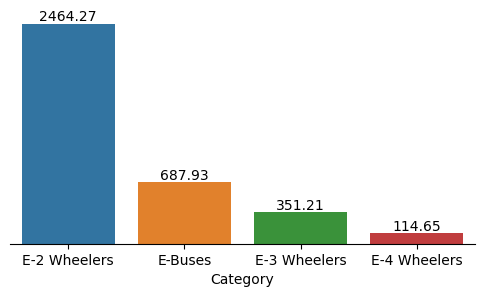

In [172]:
fig, ax = plt.subplots(figsize = (6, 3))
ax = sns.barplot(data=df['EV Market'], x = 'Category', y = 'Amount INR Cr')
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.ylabel("")
ax.spines[['right', 'top', 'left']].set_visible(False)
plt.savefig('indias_ev_industry.png', format = 'png')

plt.show()

In [58]:
ev2w = list(df.keys())[0:4]
data_ev2w = pd.concat([df[ev2w[0]], df[ev2w[1]], df[ev2w[2]], df[ev2w[3]]])

In [61]:
data_ev2w['maker'] = data_ev2w['maker'].str.upper()

In [62]:
np.sort(data_ev2w['maker'].unique())


array(['AMPERE', 'AMPERE VEHICLES', 'ATHER', 'ATHER ENERGY', 'BAJAJ',
       'BEING INDIA', 'BENLING', 'HERO ELECTRIC', 'JITENDRA',
       'JITENDRA NEW EV', 'OKAYA EV', 'OKINAWA', 'OKINAWA AUTOTECH',
       'OLA ELECTRIC', 'OTHERS', 'PURE EV', 'REVOLT', 'TVS'], dtype=object)

In [65]:
data_ev2w['maker'] = data_ev2w['maker'].replace('AMPERE VEHICLES', 'AMPERE').replace('ATHER ENERGY', 'ATHER').replace('BEING INDIA', 'BENLING').replace('JITENDRA NEW EV', 'JITENDRA').replace('OKINAWA AUTOTECH', 'OKINAWA')


In [66]:
np.sort(data_ev2w['maker'].unique())


array(['AMPERE', 'ATHER', 'BAJAJ', 'BENLING', 'HERO ELECTRIC', 'JITENDRA',
       'OKAYA EV', 'OKINAWA', 'OLA ELECTRIC', 'OTHERS', 'PURE EV',
       'REVOLT', 'TVS'], dtype=object)

In [67]:
data_ev2w

,financial_year,maker,market_share,month,num_vehicles
0,2019-20,HERO ELECTRIC,0.30,Apr,1776
1,2019-20,HERO ELECTRIC,0.30,May,455
2,2019-20,HERO ELECTRIC,0.30,Jun,329
3,2019-20,HERO ELECTRIC,0.30,Jul,260
4,2019-20,HERO ELECTRIC,0.30,Aug,249
...,...,...,...,...,...
151,2022-23,OTHERS,0.08,Nov,5241
152,2022-23,OTHERS,0.08,Dec,5233
153,2022-23,OTHERS,0.08,Jan,5111
154,2022-23,OTHERS,0.08,Feb,5083


In [68]:
data_ev2w_year = data_ev2w.groupby(['financial_year', 'maker']).agg({'num_vehicles':'sum'}).reset_index()


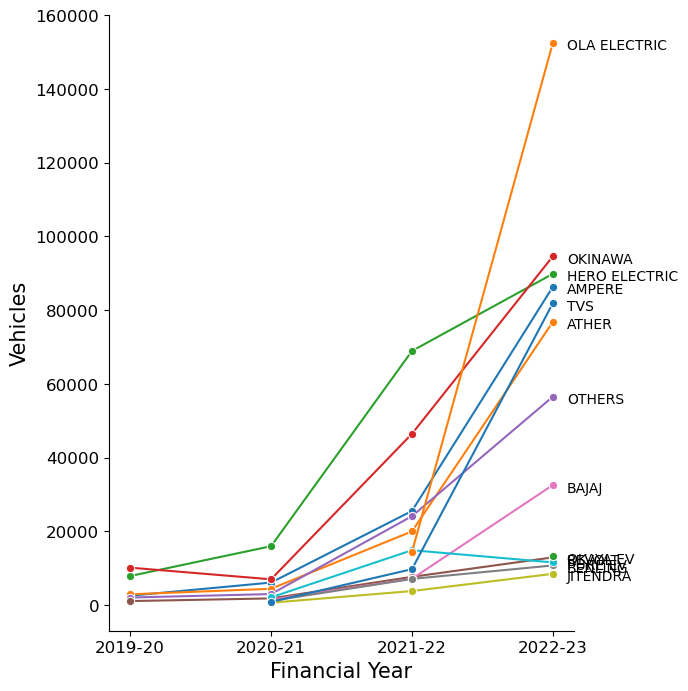

In [69]:

fig, ax = plt.subplots(figsize=(6,8))
ax = sns.lineplot(data=data_ev2w_year, x='financial_year', y='num_vehicles', hue='maker', marker='o', palette='tab10')
plt.xlabel("Financial Year", fontsize = 15)
plt.ylabel("Vehicles", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(title='Maker')

# Annotate the last data point
for col in data_ev2w_year['maker'].unique()[::1]:
    last_point = data_ev2w_year[data_ev2w_year['maker'] == col].iloc[-1]
    plt.annotate(f"{last_point['maker']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().set_visible(False)
plt.savefig('ev_2w.png', format = 'png')
plt.show()

"The figure provides a snapshot of the electric two-wheeler industry, with Ola Electric emerging as the top performer in 2023. This demonstrates the company's market leadership and the overall competitiveness of the sector."

Electric two-wheeler customer reviews from bikewale.com along with technical specifications and pricing information were used to understand customer behavior, preferences, and buying decisions (psychographic and behavioral insights). This data was also crucial for assessing technical feasibility and price points, which are both important factors in segmenting the electric two-wheeler market.

In [70]:
df_bw = pd.read_csv('ev2_bikewale.csv')
df_model = pd.read_csv('ev_model_spec.csv')

In [71]:
df_ve = df_bw.merge(df_model, how='left', on='Model Name')

In [72]:
df_ve.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000


<AxesSubplot:>

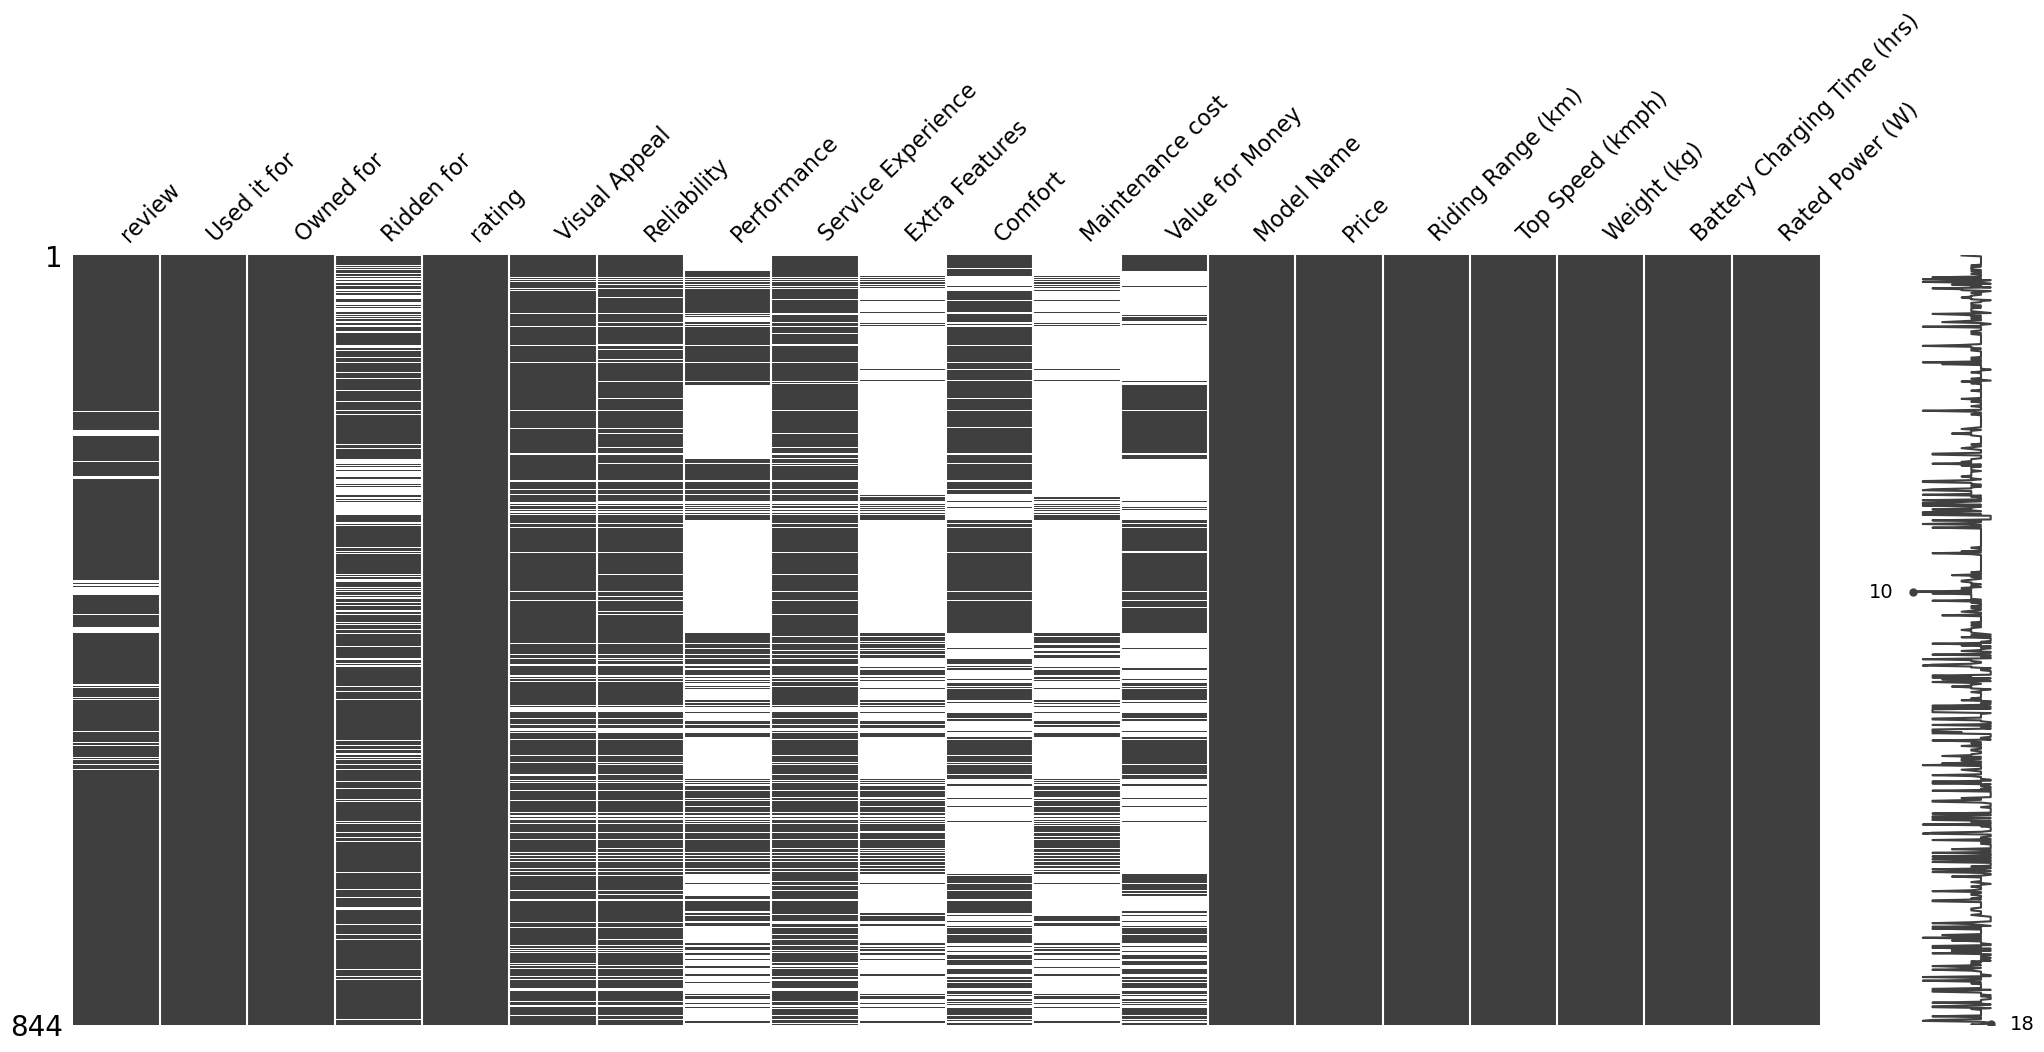

In [73]:
msno.matrix(df_ve)

In [75]:
((df_ve.isnull().sum() * 100/df_ve.shape[0])).sort_values(ascending = False)


Maintenance cost               78.672986
Extra Features                 78.080569
Performance                    59.123223
Value for Money                53.791469
Comfort                        37.203791
Ridden for                     20.853081
Service Experience             16.706161
Reliability                    15.165877
Visual Appeal                  12.440758
review                          5.568720
Used it for                     0.000000
rating                          0.000000
Owned for                       0.000000
Model Name                      0.000000
Price                           0.000000
Riding Range (km)               0.000000
Top Speed (kmph)                0.000000
Weight (kg)                     0.000000
Battery Charging Time (hrs)     0.000000
Rated Power (W)                 0.000000
dtype: float64

In [77]:
df_ve.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 843
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review                       797 non-null    object 
 1   Used it for                  844 non-null    object 
 2   Owned for                    844 non-null    object 
 3   Ridden for                   668 non-null    object 
 4   rating                       844 non-null    int64  
 5   Visual Appeal                739 non-null    float64
 6   Reliability                  716 non-null    float64
 7   Performance                  345 non-null    float64
 8   Service Experience           703 non-null    float64
 9   Extra Features               185 non-null    float64
 10  Comfort                      530 non-null    float64
 11  Maintenance cost             180 non-null    float64
 12  Value for Money              390 non-null    float64
 13  Model Name          

In [82]:
sentiments = SentimentIntensityAnalyzer()
sentiments_list = []

for review_text in df_ve['review']:
    if pd.isna(review_text):
        sentiments_list.append('neutral')
        continue
    sentiment_scores = sentiments.polarity_scores(review_text)

    positive_score = sentiment_scores['pos']
    negative_score = sentiment_scores['neg']

    if positive_score > negative_score:
        sentiment_label = 'positive'
    elif positive_score < negative_score:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    sentiments_list.append(sentiment_label)
    
df_ve['sentiment'] = sentiments_list

In [83]:
df_ve['sentiment'].value_counts()

positive    527
negative    264
neutral      53
Name: sentiment, dtype: int64

In [84]:
df_segment = df_ve[['Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'sentiment']].copy()

In [85]:
df_segment.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,sentiment
0,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,negative
1,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,negative
2,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,positive
3,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,negative
4,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,negative


In [86]:
df_segment = df_ve.iloc[:,5:13].copy()

In [87]:
df_segment = df_segment.fillna(0.)

In [88]:
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 843
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Visual Appeal       844 non-null    float64
 1   Reliability         844 non-null    float64
 2   Performance         844 non-null    float64
 3   Service Experience  844 non-null    float64
 4   Extra Features      844 non-null    float64
 5   Comfort             844 non-null    float64
 6   Maintenance cost    844 non-null    float64
 7   Value for Money     844 non-null    float64
dtypes: float64(8)
memory usage: 59.3 KB


In [89]:
df_segment.mean()

Visual Appeal         3.309242
Reliability           2.811611
Performance           1.441943
Service Experience    2.619668
Extra Features        0.643365
Comfort               2.300948
Maintenance cost      0.723934
Value for Money       1.562796
dtype: float64

In [90]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_segment)

In [91]:
pca = PCA(random_state=42)
pca.fit(df_scaled)

PCA(random_state=42)

In [92]:
df_pca = pca.transform(df_scaled)

In [94]:
df_pca = pd.DataFrame(df_pca, columns = [f'PC{x +1}' for x in range(len(df_segment.columns))])


In [95]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.291227,-1.038055,0.354864,-0.623469,-1.102720,-0.169287,-0.438012,0.957827
1,0.710801,-1.394405,-0.360466,-0.621671,0.320899,-0.086053,-0.426279,-0.149917
2,-0.849149,-1.189765,0.167683,-0.410898,-0.409054,-0.191904,-0.329993,0.830738
3,1.967022,-0.878935,-0.100197,0.330003,-0.075822,0.069599,0.013068,0.011328
4,0.078940,-1.017161,-0.079210,-0.324132,-0.961554,0.005517,-0.107260,0.427972


In [96]:
pca_summary = pd.DataFrame({'Standard Deviation':df_pca.std(),
                           'Proportion of Variance': pca.explained_variance_ratio_,
                           'Cumultive Proportion': pca.explained_variance_ratio_.cumsum()})

In [97]:
pca_summary

,Standard Deviation,Proportion of Variance,Cumultive Proportion
PC1,1.845017,0.425007,0.425007
PC2,1.736646,0.376546,0.801553
PC3,0.903486,0.101915,0.903468
PC4,0.517750,0.033468,0.936936
PC5,0.405239,0.020503,0.957439
PC6,0.379558,0.017987,0.975426
PC7,0.337883,0.014254,0.989680
PC8,0.287510,0.010320,1.000000


In [99]:
factor_loadings = pd.DataFrame(pca.components_, columns = df_segment.columns, index = df_pca.columns).T


In [100]:
factor_loadings.style.background_gradient(cmap = 'Blues')


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Visual Appeal,-0.480170,0.117814,0.063320,-0.730598,0.247014,0.105903,0.375474,0.067539
Reliability,-0.494758,0.124910,-0.002776,0.152447,-0.819319,0.060484,0.117211,0.166384
Performance,-0.128721,0.459145,0.574833,-0.005549,-0.019902,-0.025704,-0.288468,-0.598232
Service Experience,-0.486499,0.100691,-0.054176,0.653781,0.470391,0.052432,0.311210,-0.044129
Extra Features,-0.024373,0.519633,-0.364578,-0.023208,0.116821,0.559390,-0.456829,0.246323
Comfort,-0.418255,-0.304266,0.249807,-0.020111,0.172621,-0.296656,-0.623271,0.404238
Maintenance cost,0.005912,0.513208,-0.386495,-0.054822,0.020302,-0.762039,-0.003360,0.055435
Value for Money,-0.309572,-0.351548,-0.563840,-0.107598,-0.046688,0.009572,-0.260855,-0.617065


In [101]:
index_names = factor_loadings.index

# Plot data points
sns.scatterplot(df_pca, x = 'PC1', y = 'PC2', color = 'grey')

# Plot arrows from centroid to provided coordinates with index names
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text((factor_loadings['PC1'][i] * 3.5), factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')

# Set labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('A Principal components analysis of the EV 2-Wheeler data set')
plt.grid(True)
plt.savefig("pca_2w.png", format = 'png')
plt.show()

ValueError: Could not interpret value `PC2` for parameter `y`

In [103]:
df_km28 = [KMeans(n_clusters = k, random_state = 42).fit(df_scaled) for k in range(2, 9)]


In [104]:
wcss = [model.inertia_ for model in df_km28]


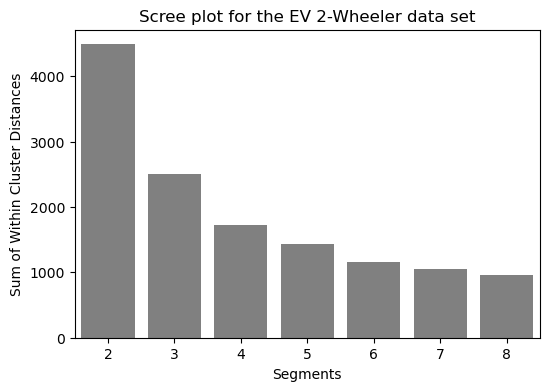

In [105]:
fig = plt.figure(figsize = (6,4))
sns.barplot(x = list(range(2, 9)), y = wcss, color = 'grey')
plt.xlabel("Segments")
plt.ylabel('Sum of Within Cluster Distances')
plt.title("Scree plot for the EV 2-Wheeler data set")
plt.savefig("scree_plot.png")
plt.show()

In [106]:
wcss_diff = pd.DataFrame({'Segments':range(2,9),
                          'WCSS Difference': pd.Series(wcss).diff()})
wcss_diff['WCSS Difference'][0] = 0

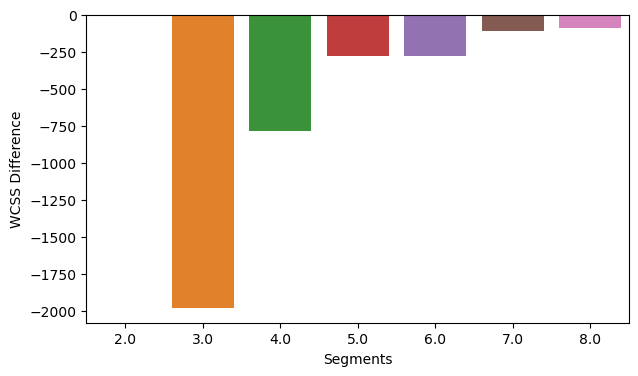

In [120]:
plt.figure(figsize = (7, 4))
sns.barplot(data=wcss_diff, x = 'Segments', y = 'WCSS Difference')
plt.savefig("wcss_diff.png")
plt.show()


The decision-making process was significantly guided by the scree plot above, revealing a distinct elbow at four segments. This marked point indicated a substantial reduction in distances, signifying the optimal number of segments for our analysis.

In [121]:
kmeans = df_km28[2]

In [122]:
df_clust = pd.DataFrame(df_scaled, columns=df_segment.columns)
df_clust['cluster'] = kmeans.labels_

In [125]:
data_pca = df_pca.copy()

In [126]:
data_pca['cluster'] = kmeans.labels_

### Profiling Segments


In [127]:
df_profile = df_segment.copy()
df_profile['cluster'] = kmeans.labels_

In [130]:
columns_segment = df_clust.columns
df_pivot = df_profile[columns_segment].groupby('cluster').mean().T

In [131]:
df_pivot_mean = df_pivot.mean(axis=1).reset_index()
df_pivot_mean.columns = ['Variable','Value']

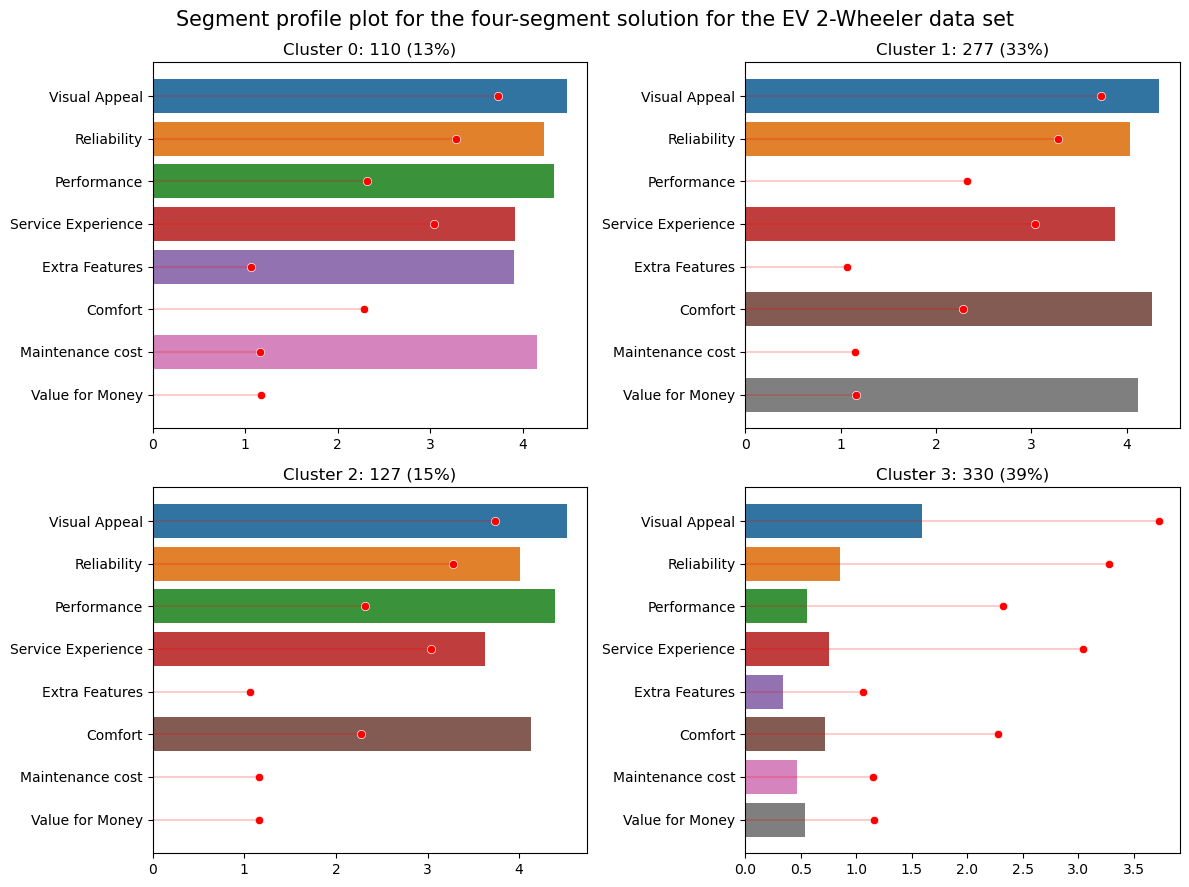

In [135]:
plt.figure(figsize = (12, 9))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.barplot(data=df_pivot, x = i, y = df_pivot.index)
    sns.scatterplot(data=df_pivot_mean, x = 'Value', y = 'Variable', color = 'red')
    for index, row in df_pivot_mean.iterrows():
        plt.hlines(y=row['Variable'], xmin=0, xmax=row['Value'], colors='red', alpha = 0.2)
    plt.ylabel("")
    plt.xlabel("")
    plt.title(f"Cluster {i}: {df_profile['cluster'].value_counts()[i]} ({df_profile['cluster'].value_counts()[i]*100/len(df_profile):.0f}%)")
plt.suptitle("Segment profile plot for the four-segment solution for the EV 2-Wheeler data set", fontsize = 15)
plt.tight_layout()
plt.savefig("segment_profile.png")
plt.show()

The graph effectively illustrates distinct consumer preferences within the electric two-wheeler market.

Segment 0 (15%) represents a quality-conscious group prioritizing visual appeal, reliability, performance, and overall customer experience.

Segment 1 (39%) comprises the largest but least satisfied group, expressing general dissatisfaction with the product.

Segment 2 (33%) values a strong combination of visual appeal, reliability, service, comfort, and affordability.

Segment 3 (13%) is a smaller group with a specific focus on advanced features, maintenance costs, in addition to the core factors valued by other segments.

These insights provide valuable information for tailoring product offerings, marketing strategies, and customer service initiatives to address the specific needs and expectations of each segment.

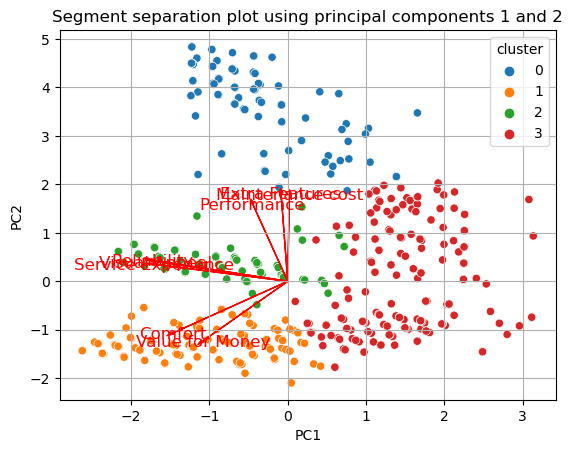

In [142]:
index_names = factor_loadings.index
sns.scatterplot(data=data_pca, x='PC1',y='PC2',hue='cluster',palette='tab10')
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text(factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Segment separation plot using principal components 1 and 2')
plt.grid(True)
plt.savefig("segment_separation.png")
plt.show()


The PCA analysis effectively underscores the distinct characteristics of each consumer segment.

Segment 1: This group stands out as a large yet undefined cluster. Their lack of clear positioning on the PCA plot indicates a general dissatisfaction or indifference across various product attributes.
Other Segments: These segments are likely more clearly positioned on the plot, revealing specific preferences and priorities.

### Describing Segments


In [149]:
data_desc = df_ve.copy()
data_desc['cluster'] = kmeans.labels_

In [174]:
def mosaicplot(df, color_list, figsize=(5,5), barwidth = 1, title = "Simple Mosaic Plot", xlabel = 'cat'):
    
    fig, ax = plt.subplots(figsize =figsize)
    
    # Convert to ratio of each row sum and do a cumsum along row
    p_cnt_ratio_df = df.div(df.sum(1), axis =0)
    ratio_cum_df = p_cnt_ratio_df.cumsum(axis=1)
    
    # Get column order.
    col_order = ratio_cum_df.columns.tolist()
        
    x = [str(n) for n in ratio_cum_df.index.tolist()]
    
    # Do the actual plots
    for col, colour in zip(col_order[::-1], color_list):
        plt.bar(x, ratio_cum_df[col], color=colour, edgecolor='white', width=barwidth, label=col)
        
    # Add in legend
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    

    # Configure title and axis
    plt.title(title)
    plt.xlabel("Segments")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([])
    plt.show()
    plt.savefig('mosaicplot.png', format = 'png')



In [152]:
color_list = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F']


In [153]:
sentiment_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['sentiment'])


In [154]:
sentiment_cluster


sentiment,negative,neutral,positive
cluster,,,
0,17,0,93
1,30,41,206
2,13,4,110
3,204,8,118


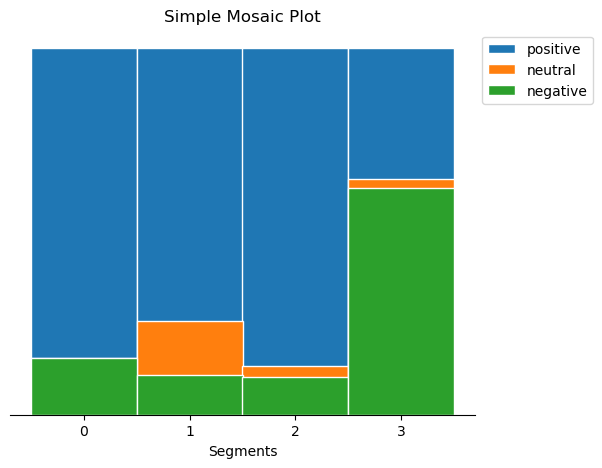

In [155]:
mosaicplot(sentiment_cluster, color_list[:3], figsize=(6,5), barwidth = 1)


The mosaic plot effectively visualizes the distribution of consumer sentiments across different segments.

Segment 1: This segment is clearly differentiated by a predominance of negative sentiment, indicating overall dissatisfaction among customers.

Other segments: These groups exhibit varying degrees of positive sentiment, suggesting a more favorable overall perception of the product.

In [156]:
used_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Used it for'])


In [157]:
used_cluster


Used it for,Daily Commute,Everything,Leisure Rides,Occasional Commute,Tours
cluster,,,,,
0,87,19,2,1,1
1,194,55,7,19,2
2,75,39,4,9,0
3,244,47,7,27,5


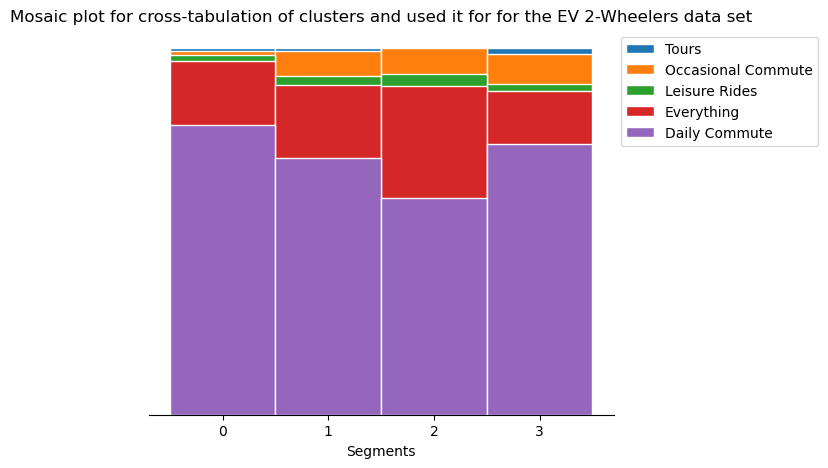

<Figure size 640x480 with 0 Axes>

In [175]:
mosaicplot(used_cluster, color_list[:5], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and used it for for the EV 2-Wheelers data set' )


The mosaic plot indicates that the primary use for electric two-wheelers across all consumer segments is daily commuting. While there is some usage for other purposes like touring, occasional commuting, and leisure, these activities are less common.

In [159]:
owned_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Owned for'])


In [160]:
owned_cluster


Owned for,3-6 months,6 months-1 yr,< 3 months,> 1 yr,Never owned,Occasional Commute
cluster,,,,,,
0,14,14,43,20,19,0
1,41,51,79,56,50,0
2,16,14,31,10,56,0
3,40,55,67,117,50,1


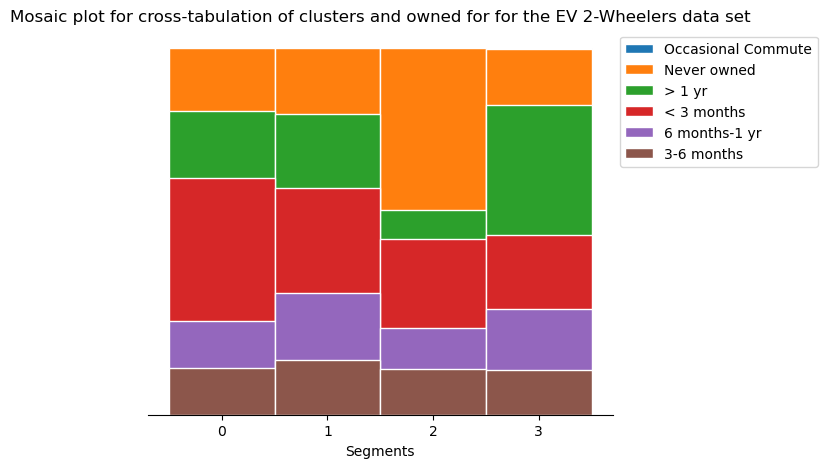

In [161]:
mosaicplot(owned_cluster, color_list[:6], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and owned for for the EV 2-Wheelers data set' )


Above mosaic plot delineates the ownership duration of electric vehicles among segments. Segment 1 stands out, owning electric vehicles for more than a year, while Segment 0 has no prior ownership experience. Segment 2 members moderately own vehicles ranging from less than 3 months to over a year, and Segment 3 consumers have owned electric vehicles for a few days to less than 3 months.

In [162]:
ridden_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Ridden for'])


In [163]:
ridden_cluster


Ridden for,10000-15000 kms,5000-10000 kms,< 5000 kms,> 15000 kms,Never owned
cluster,,,,,
0,5,18,63,5,0
1,11,44,158,14,0
2,1,15,54,1,0
3,15,61,184,18,1


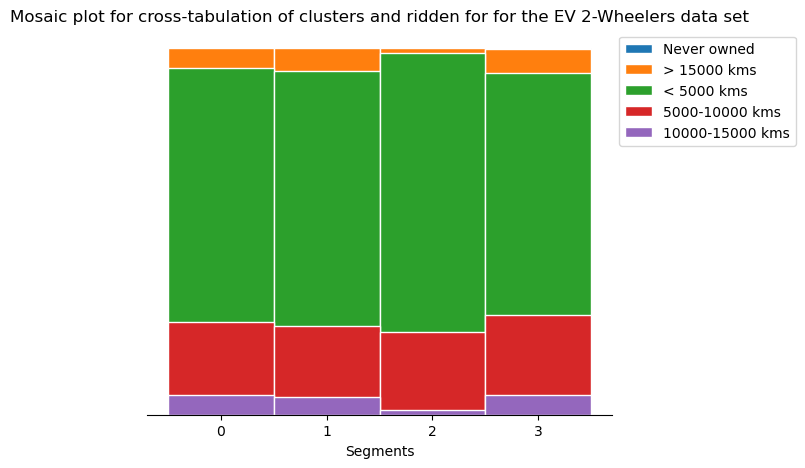

In [164]:
mosaicplot(ridden_cluster, color_list[:5], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and ridden for for the EV 2-Wheelers data set' )


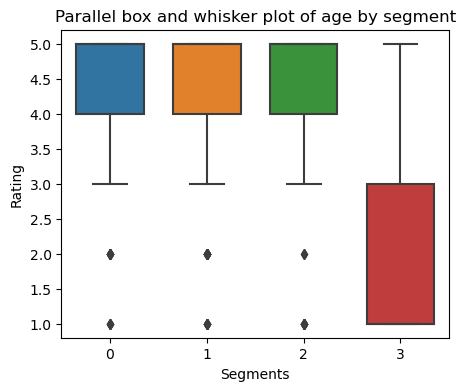

In [166]:
# Number of cluster along the x-axis and rating along the y-axis
plt.figure(figsize = (5,4))
sns.boxplot(data=data_desc, x= 'cluster', y = 'rating', palette = 'tab10', width = 0.7)
plt.xlabel("Segments")
plt.ylabel("Rating")
plt.title("Parallel box and whisker plot of age by segment")
plt.savefig("rating.png")
plt.show()

In [167]:
data_desc.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,...,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment,cluster
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,...,1.0,TVS iQube,137890,100,78,117,5,3000,negative,3
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,...,3.0,TVS iQube,137890,100,78,117,5,3000,negative,3
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,...,2.0,TVS iQube,137890,100,78,117,5,3000,positive,1
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,...,1.0,TVS iQube,137890,100,78,117,5,3000,negative,3
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,...,2.0,TVS iQube,137890,100,78,117,5,3000,negative,1


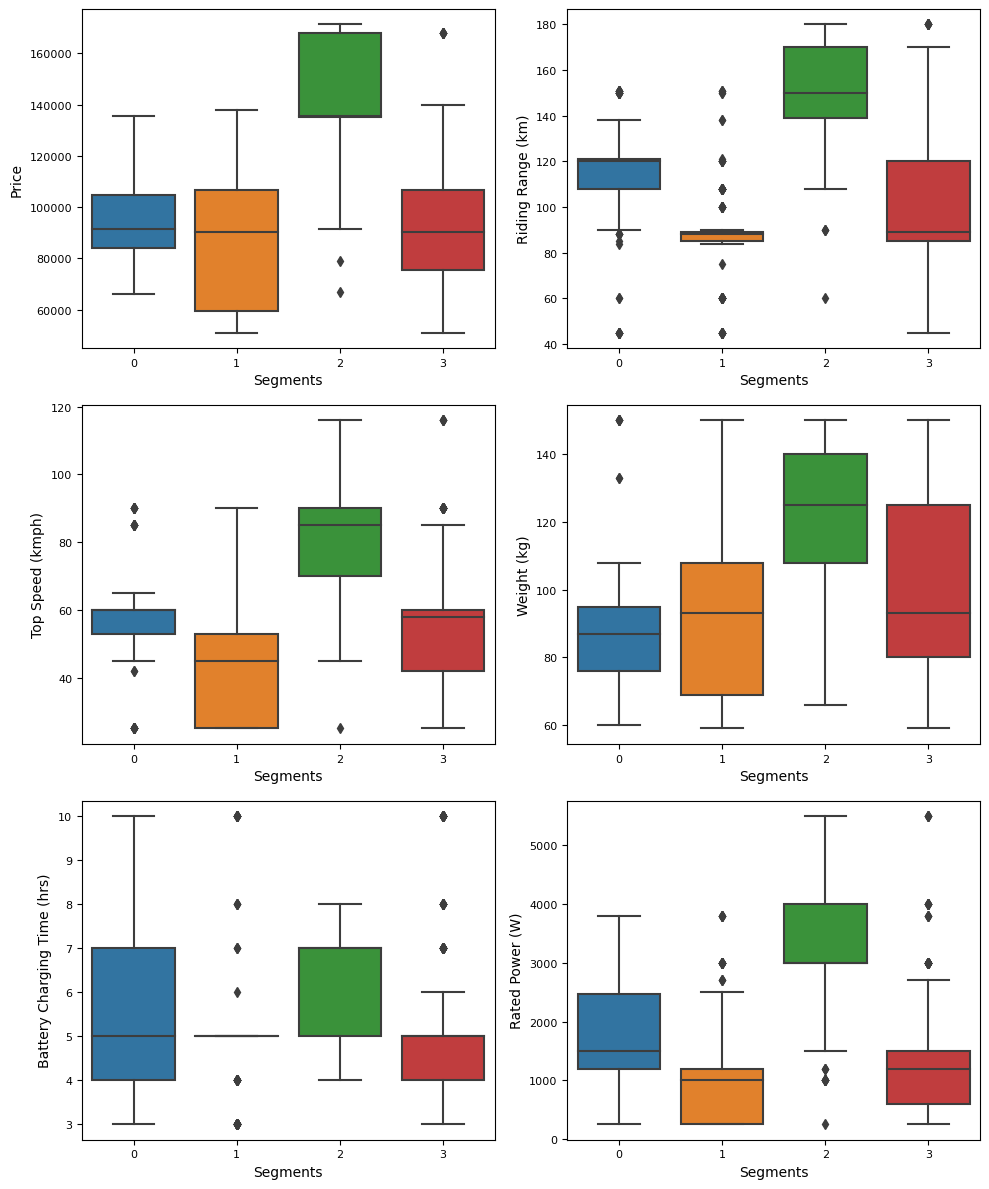

<Figure size 640x480 with 0 Axes>

In [176]:
plt.figure(figsize = (10, 12))
for i, col in enumerate(data_desc.columns[-8:-2]):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=data_desc, x = 'cluster', y =col)
    plt.xlabel("Segments", fontsize= 10)
    plt.ylabel(col, fontsize = 10)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()
plt.savefig('selection_plot.png',format='png')


In analyzing technical specification of electric vehicles across different segments, distinct patterns emerge. Segment 0 prefers premium EVs with a higher price range and extended riding range, emphasizing consumer preference for luxury and long-distance travel. Segment 1 focuses on budget-friendly options with lower prices and moderate riding ranges, suitable for daily commuting. Segment 2 and Segment 3 prioritize affordability, with slight differences in riding range and speed preferences. Weight preferences vary, with Segment 0 and Segment 1 favoring heavier vehicles, while Segment 2 and Segment 3 prefer lighter options. Charging time also differs, with Segment 0 and Segment 3 opting for longer durations for overnight charging, while Segment 1 and Segment 2 prioritize faster charging for quick turnaround times. These nuanced preferences shape the electric vehicle market in India.

### Selection of Target Segment


To effectively target the strategic segments within the electric vehicle (EV) market, the following tailored approach can be adopted:

Segment 1 (39% of Consumers)
Diverse Preferences: This segment exhibits a wide range of preferences, indicating the need for flexible and customizable EV options. Offering different configurations, such as battery capacity, driving range, and interior features, can cater to their varied demands.

Dissatisfaction Points: Identifying and addressing the specific dissatisfaction points—such as range anxiety, charging infrastructure, or pricing—can improve customer satisfaction. This may involve enhancing the charging network, providing clear cost-benefit analysis, and offering customer education on EV ownership.

Strategy: Focus on personalizing the EV experience for Segment 1 by offering a range of options that meet their specific needs. Marketing efforts should highlight the ability to customize and adapt the vehicle to individual lifestyles.

Segment 2 (33% of Consumers)
Visual Appeal: Segment 2 places a high value on the design and aesthetics of the vehicle. The strategy should include the development of visually appealing models, with a focus on modern, sleek, and stylish designs that resonate with this segment's preferences.

Reliability and Service Experience: Emphasize the reliability of EVs and provide an exceptional service experience. This can be achieved through robust warranties, easy access to service centers, and a seamless after-sales experience.
Comfort: Highlight the comfort features of the vehicle, such as spacious interiors, advanced infotainment systems, and smooth driving experiences.

Value for Money: This segment is sensitive to value, so the strategy should involve clearly communicating the long-term cost savings associated with EV ownership, such as lower maintenance and fuel costs.

Overall Strategy
Segment-Specific Marketing: Develop targeted marketing campaigns that align with the distinct expectations of each segment. For Segment 1, emphasize customization and addressing dissatisfaction points, while for Segment 2, focus on design, reliability, comfort, and value for money.

Product Development: Invest in product features that align with the preferences of each segment. For Segment 1, this might involve offering a range of configurations, while for Segment 2, it could mean enhancing the design and comfort features.

Customer Feedback Loop: Continuously gather feedback from these segments to refine and adapt the product offerings and marketing strategies, ensuring ongoing alignment with consumer expectations.

By addressing the unique needs of Segment 1 and enhancing the positive elements valued by Segment 2, the strategy will not only improve customer satisfaction and loyalty but also position the brand to achieve a competitive advantage and sustain market growth in the EV industry.